# A/B tests с Python



# Урок 8. Python применение проверки на практике - пайплайн оценки A/B
## Задание
На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.<br>
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.


<a id="Libraries"></a>
##  Загрузка библиотек

In [157]:
from scipy.stats import ttest_1samp
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')



In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Рассмотрим кейс с рекламной выручкой

 В приложенном excel файле вы найдете сырые данные - доход принесенный пользователем revenue.

# Подготовка данных

In [159]:
#Подгружаем данные
data = pd.read_excel('AB_Test_Results (2).xlsx')

In [160]:
data.head(15)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.00
1,2423,control,0.00
2,9411,control,0.00
3,7311,control,0.00
4,6174,variant,0.00
5,2380,variant,0.00
6,2849,control,0.00
7,9168,control,0.00
8,6205,variant,0.00
9,7548,control,0.00


In [161]:
# Информация по датасету
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [162]:
# Размерность датасета
data.shape

(10000, 3)

In [163]:
# Посмотрим основные статистики
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [164]:
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

Пропущенных данных нет.

In [165]:
data.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

Объём выборок в каждой группе примерно одинаковый.<br>
Посмотрим только те данные, где пользователь принёс доход.

In [166]:
data[data['REVENUE']!=0]

,USER_ID,VARIANT_NAME,REVENUE
13,2529,variant,2.15
49,6429,control,3.25
139,3331,variant,4.27
149,8110,variant,1.75
152,8607,control,2.99
...,...,...,...
9651,9928,variant,1.25
9711,6468,control,2.93
9724,5205,control,14.17
9725,702,variant,2.92


Таких строк всего 152 из 10000.<br>
Посмотрим на группы по отдельности

In [167]:
data[data['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE
count,4984.000000,4984.000000
mean,4989.436798,0.129013
std,2905.145109,3.007524
min,2.000000,0.000000
25%,2466.000000,0.000000
50%,4964.500000,0.000000
75%,7576.250000,0.000000
max,10000.000000,196.010000


In [168]:
data[data['VARIANT_NAME']=='variant'].describe()

,USER_ID,REVENUE
count,5016.000000,5016.000000
mean,4972.776914,0.070070
std,2876.320625,1.314802
min,3.000000,0.000000
25%,2476.500000,0.000000
50%,4958.500000,0.000000
75%,7415.250000,0.000000
max,10000.000000,58.630000


Пока мы еще ничего не посчитали, но уже можно заметить, что максимальный доход в контрольной группе больше в 3.38 раза, чем в тестовой группе. Все мы знаем, что среднее очень неустойчиво к выбросам, так что нам необходимо будет это учесть.

#Проверка на нормальность распределения и применение статистических критериев

##Метрика доход на юзера

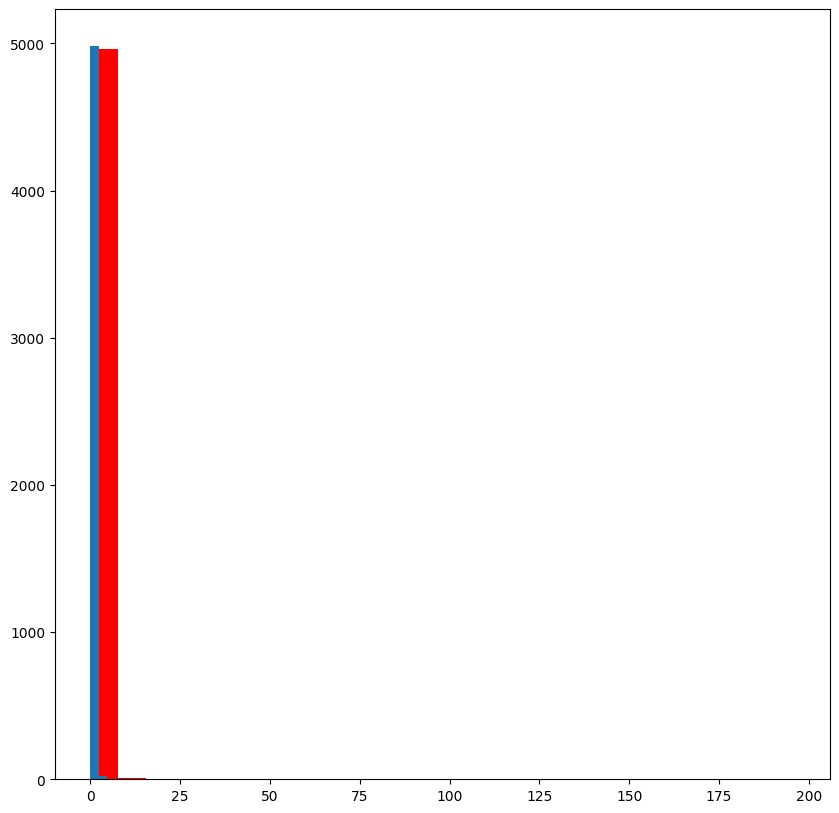

In [169]:
plt.figure(figsize=(10, 10))
control_visit_all = data['REVENUE'][data['VARIANT_NAME'] == 'control']
test_visit_all =data['REVENUE'][data['VARIANT_NAME'] == 'variant']

plt.hist(control_visit_all, color='r', bins=25)
plt.hist(test_visit_all,  bins=25)

plt.show()

Мы видим, что данные распределены экспонициально и у нас очень много юзеров с нулевым доходом.

In [170]:
data[data['REVENUE']==0].shape

(9848, 3)

Проверим **нормальность распределения данных**.<br>
Используем тест ***Шапиро‑Уилка***, он подойдет в большинстве случаев:

In [171]:
from scipy.stats import shapiro, norm

In [172]:
# Применяем тест Шапиро-Уилка
alpha = 0.05
st, p = shapiro(data.REVENUE)
print(f"stat = {st}, p-value = {p}")
if p > alpha:
    print("Нормальное распределение")
else:
    print("Не нормальное распределение")

stat = 0.018358170986175537, p-value = 0.0
Не нормальное распределение


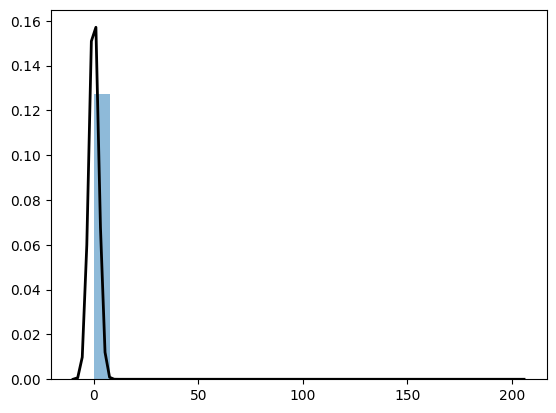

In [173]:
# График с распределением
fig, ax = plt.subplots()
ax.hist(data.REVENUE, bins=25, density=True, alpha=0.5, label='Data')

mu, std = norm.fit(data.REVENUE)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2, label='Normal distribution')

Дальше мы могли бы провести самый используемый метод проверки отсутствия нулевой гипотезы, а именно t‑test, наиболее известным является т‑критерий стъюдента. Но по графику и тесту Шапиро-Уилка мы видим, что у нас распределение не является нормальным.

В этом случае лучше всего подходит ***U‑test Манна‑Уитни***, В отличие от параметрических тестов, таких как t‑тест Стьюдента или t‑test Уэлча, U‑test Манна‑Уитни не делает никаких предположений о форме базового распределения.<br>
Но это непараметрический тест, рассмотрим его ниже для Метрики доля юзеров с доходом.

##Метрика доля юзеров с доходом

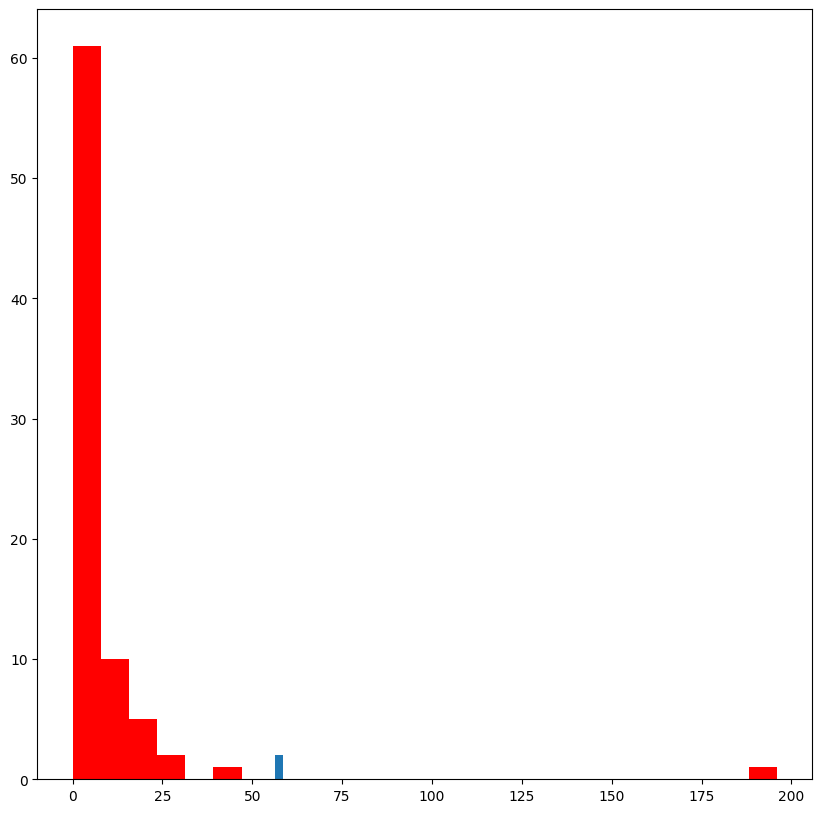

In [174]:
plt.figure(figsize=(10, 10))
control_visit = data['REVENUE'][(data['VARIANT_NAME'] == 'control')&(data['REVENUE'] != 0)]
test_visit =data['REVENUE'][(data['VARIANT_NAME'] == 'variant')&(data['REVENUE'] != 0)]

plt.hist(test_visit,  bins=25)
plt.hist(control_visit, color='r', bins=25)

plt.show()

In [175]:
data['REVENUE'].value_counts()

0.00     9848
1.25       10
1.01        6
3.25        6
0.04        5
         ... 
2.19        1
2.14        1
17.08       1
2.00        1
2.92        1
Name: REVENUE, Length: 101, dtype: int64

Соотношение юзеров к доходу - это метрика пропорций, можно использовать ***z-test***.

In [176]:
k1 = control_visit.shape[0]
k2 = test_visit.shape[0]
k1, k2

(80, 72)

In [177]:
n1 = data[data['VARIANT_NAME']=='control'].shape[0]
n2 = data[data['VARIANT_NAME']=='variant'].shape[0]
n1, n2

(4984, 5016)

In [178]:
from statsmodels.stats import proportion

In [179]:
z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]),
                                                 np.array([n1, n2]))
print('Результаты z_score = %.3f, p-value = %.3f'%(z_score, z_pvalue))

Результаты z_score = 0.694, p-value = 0.488


In [180]:
if abs(z_pvalue) < 0.05:
    print("Мы можем отвергнуть нулевую гипотезу! Стат. значимость существует.")
else:
    print("Мы не можем отвергнуть нулевую гипотезу. Стат. значимость не обнаружена.")

Мы не можем отвергнуть нулевую гипотезу. Стат. значимость не обнаружена.


Наилучший метод чтобы проверить статистическую значимость изменения для пропорций это метод Хи‑Квадрат.<br>
***Непараметрический Хи-квадрат:***

In [181]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]),
                                                        np.array([n1, n2]))

# Рассчитаем доверительный интервал для изменения
lift = (n1/n2)/(k1/k2)
std_error = np.sqrt(1/n1 + 1/n2 + 1/k1 + 1/k2)
ci = norm.interval(0.95, loc=lift, scale=std_error)

# Выводим результаты
print(f"Хи-квадрат = {chisq} p-value = {pvalue}")
print("Доверительный интервал изменения: ", ci)

# Проверяем есть ли изменение
if pvalue < 0.05 and ci[0] > 1:
    print("Вариант лучше.")
else:
    print("Стат.разницы нет.")

Хи-квадрат = 0.4811270952822227 p-value = 0.48791223187088606
Доверительный интервал изменения:  (0.5734649361569243, 1.2150518102545589)
Стат.разницы нет.


In [182]:
if abs(pvalue) < 0.05:
    print("Мы можем отвергнуть нулевую гипотезу! Стат. значимость существует.")
else:
    print("Мы не можем отвергнуть нулевую гипотезу. Стат. значимость не обнаружена.")

Мы не можем отвергнуть нулевую гипотезу. Стат. значимость не обнаружена.



***Непараметрический критерий Манна-Уитни:***

In [183]:
data.groupby('VARIANT_NAME')['REVENUE'].describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,4984.0,0.129013,3.007524,0.0,0.0,0.0,0.0,196.01
variant,5016.0,0.070070,1.314802,0.0,0.0,0.0,0.0,58.63


In [184]:
from scipy.stats import mannwhitneyu

In [185]:
mw_stats = mannwhitneyu(x=data[(data['VARIANT_NAME'] == 'control')&(data['REVENUE'] != 0)]['REVENUE'].values,
                        y=data[(data['VARIANT_NAME'] == 'variant')&(data['REVENUE'] != 0)]['REVENUE'].values,
                        alternative='two-sided')
mw_stats

MannwhitneyuResult(statistic=3356.0, pvalue=0.07924299810603061)

In [186]:
print("Mann-Whitney U-test:")
print("U-statistic: ", mw_stats[0])
print("p-value:     ", mw_stats[1])

Mann-Whitney U-test:
U-statistic:  3356.0
p-value:      0.07924299810603061


Стат. значимость не обнаружена.

##Поработаем с данными кейса. Почистим данные.

**Избавимся от некорретных строк.** Посчитаем, сколько типов групп встречается у каждого пользователя.

In [187]:
v = data.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

In [188]:
v.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


Мы выяснили, что некоторые пользователи попали в обе группы. Это нарушает корректность наших тестов.<br>
Откорректируем наши данные.

In [189]:
more_than_one_types = v.query('VARIANT_NAME > 1')

Создадим новую выборку, где каждый пользователь будет встречаться только в одной группе.

In [190]:
data_new = data[~data.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')

In [191]:
data_new.shape

(6070, 3)

In [192]:
data.shape

(10000, 3)

В изначальных данных у нас было 10 000 пользователей.<br>
В новые данные мы забрала только тех пользователей, которые были только в одной группе.<br>
Осталось 6 070 пользователей.

In [193]:
control = data_new.query('VARIANT_NAME == "control"')

test = data_new.query('VARIANT_NAME == "variant"')

In [194]:
len(control)

3026

In [195]:
len(test)

3044

Выборки получились примерно одинаковые по объёму.

**Проверим на нормальность распределения данных** нашу новую выборку:

In [196]:
# Применяем тест Шапиро-Уилка
alpha = 0.05
st, p = shapiro(data_new.REVENUE)
print(f"stat = {st}, p-value = {p}")
if p > alpha:
    print("Нормальное распределение")
else:
    print("Не нормальное распределение")

stat = 0.015946388244628906, p-value = 0.0
Не нормальное распределение


Ничего не изменилось. Посмотрим на распределение графически:

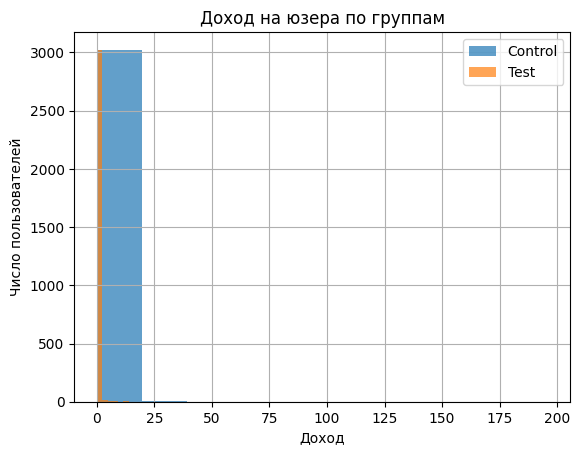

In [197]:
control.REVENUE.hist(bins = 10, alpha =0.7, label='Control')
test.REVENUE.hist(bins = 10, alpha =0.7, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

Всё осталось по-прежнему, у нас сохранилось экспонициальное распределение!

Применим ***критерий Манна-Уитни***:

In [198]:
mw_stats = mannwhitneyu(x=control.REVENUE.values,
                        y=test.REVENUE.values,
                        alternative='two-sided')
mw_stats

MannwhitneyuResult(statistic=4622832.0, pvalue=0.2444173738649208)

In [199]:
print("Mann-Whitney U-test:")
print("U-statistic: ", mw_stats[0])
print("p-value:     ", mw_stats[1])

Mann-Whitney U-test:
U-statistic:  4622832.0
p-value:      0.2444173738649208


Статистической значимых различий между выборками не обнаружено.

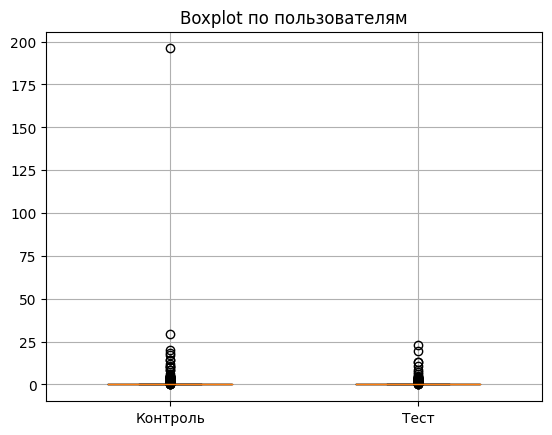

In [200]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

Мы видим, что наши данные очень сильно зашумлены, есть выбросы.

Рассмотрим _**t-критерий Стьюдента**_, который представляет собой проверку статистической гипотезы для сравнения средних значений двух выборок гауссовых переменных. Предположение или нулевая гипотеза теста состоит в том, что выборочные совокупности имеют одно и то же среднее значение, например. что между выборками нет различий или что выборки взяты из одной и той же исходной совокупности.

In [210]:
ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.403762252371675, pvalue=0.1604844017690842)

p-value > alpha<br> 0.16 > 0.5<br>
=> выборки имеют одно и то же среднее значение,<br>
между выборками нет различий.

##Расчет мощности


***Статистическая мощность проверки гипотезы*** - это вероятность обнаружения эффекта, если существует истинный эффект, который необходимо обнаружить.<br> Мощность может быть рассчитана и зарегистрирована для завершенного эксперимента, чтобы прокомментировать уверенность, которую можно иметь в выводах, сделанных на основе результатов исследования.

d = (M1 – M2) / S_pooled






## S_pooled =

  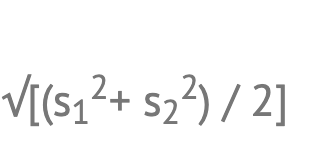

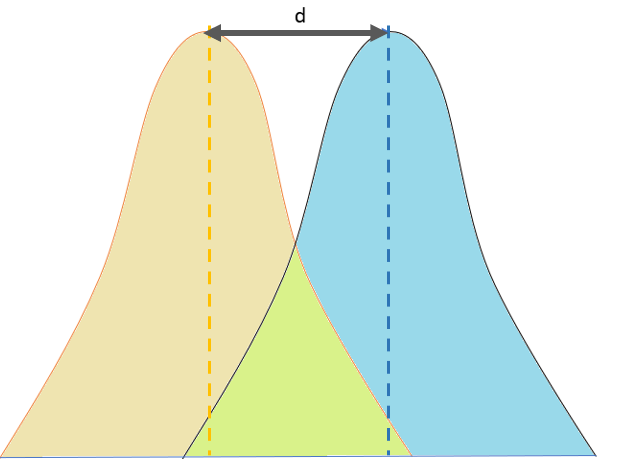

In [202]:
C_mean = control.REVENUE.values.mean()
T_mean = test.REVENUE.values.mean()

C_std = control.REVENUE.values.std()
T_std = test.REVENUE.values.std()

In [203]:
print(len(control.REVENUE.values), len(test.REVENUE.values))

3026 3044


In [204]:
n =  len(control.REVENUE.values)

In [205]:
##S = np.sqrt((sd_t**2 / n_t) + (sd_c**2 / n_c))

S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [206]:
effect = float((T_mean-C_mean)/ S)

In [207]:
from statsmodels.stats.power import TTestIndPower

In [208]:
# parameters for power analysis

alpha = 0.05

# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=None, nobs1=n, ratio=1.0, alpha=alpha)

result

0.2893670730459212

***Статистическая мощность*** — это вероятность того, что тест правильно отклонит ложную нулевую гипотезу.<br>
Получили очень маленькую мощность теста, всего примерно 29%<br>
Между выборками нет различий с вероятностью 29%

Что делать, чтобы повысить мощность теста?<br>
Возможно нам не хватает объёма выборки?

In [209]:
# вычисление размера выборок на основе количества уникальных значений USER_ID
n1 = len(data[data['VARIANT_NAME'] == 'control']['USER_ID'].unique())
n2 = len(data[data['VARIANT_NAME'] == 'variant']['USER_ID'].unique())

# вычисление ожидаемого эффекта на основе наблюдаемого эффекта
observed_effect = data[data['VARIANT_NAME'] == 'variant']['REVENUE'].mean() - data[data['VARIANT_NAME'] == 'control']['REVENUE'].mean()
effect_size = observed_effect / data['REVENUE'].std()

# задание параметров теста
alpha = 0.05  # уровень значимости
power = 0.8  # мощность теста

# вычисление мощности теста
power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=n2/n1)
power = power_analysis.power(effect_size=effect_size, nobs1=sample_size, alpha=alpha, ratio=n2/n1)

# вывод результатов
print("Требуемый размер выборки: ", sample_size)
print("Мощность теста:           ", power)

Требуемый размер выборки:  24279.943341047216
Мощность теста:            0.8000000000008908


Чтобы повысить статистическую мощность теста до 80%, нам необходимо повысить объём выборки до примерно 24 300 человек.

## Выводы:

1. У нас нет статистически значимой разницы по нашим метрикам между контрольной  и тестовой группами.
2. Тест изначательно был поставлен не корректно, некоторые пользователи попали и в контрольную, и в тестовую группы.
3. Большая дисперсия в данных.
4. Мощность теста очень маленькая, чтобы с уверенностью сказать, что у нас действительно нет статистической значимости между группами.
5. У нас недостаточный объём выборки.

##Рекомендации менеджеру:

1. Не рекомендую выкатывать изменения в продакшен.
2. Перезапустить тест. Поставить тест корректно, проверить сплитование.
3. Увеличить объём выборки до 25 000 и время проведения эксперимента.